k-Nearest-Neighbors (kNN) is a simple technique for classification. The idea behind it is that similar data points should have the same class, at least most of the time. This method is very intuitive and has proven itself in many domains including recommendation systems, anomaly detection, image/text classification and more.

In what follows we present a detailed example of a multi-class classification objective. The dataset we use contains information collected by the US Geological Survey and the US Forest Service about wilderness areas in northern Colorado. The features are measurements like soil type, elevation, and distance to water, and the labels encode the type of trees - the forest cover type - for each location. The machine learning task is to predict the cover type in a given location using the features. Overall there are seven cover types.

The notebook has two sections. In the first, we use Amazon SageMaker’s python SDK in order to train a kNN classifier in its simplest setting. We explain the components common to all Amazon SageMaker’s algorithms including uploading data to Amazon S3, training a model, and setting up an endpoint for online inference. In the second section we dive deeper into the details of Amazon SageMaker kNN. We explain the different knobs (hyper-parameters) associated with it, and demonstrate how each setting can lead to a somewhat different accuracy and latency at inference time.

This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

### Part 1: Running kNN in 5 minutes
#### Dataset

We’re about to work with the UCI Machine Learning Repository Covertype dataset [1] (covtype) (copyright Jock A. Blackard and Colorado State University). It’s a labeled dataset where each entry describes a geographic area, and the label is a type of forest cover. There are 7 possible labels and we aim to solve the mult-class classification problem using kNN. We begin by downloading the dataset from a S3 bucket and moving it to a temporary folder. It was originally downloaded from here.

[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
import boto3

region = boto3.Session().region_name

# S3 bucket where the original covtype data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-example-files-prod-{region}"
downloaded_data_prefix = "datasets/tabular/uci_covtype"
s3 = boto3.client("s3")
s3.download_file(
    downloaded_data_bucket, f"{downloaded_data_prefix}/covtype.data.gz", "covtype.data.gz"
)

In [2]:
!mkdir -p /tmp/covtype/raw
!mv covtype.data.gz /tmp/covtype/raw/covtype.data.gz

### Pre-Processing the Data
Now that we have the raw data, let’s process it. We’ll first load the data into numpy arrays, and randomly split it into train and test with a 90/10 split.

In [3]:
import numpy as np
import os

data_dir = "/tmp/covtype/"
processed_subdir = "standardized"
raw_data_file = os.path.join(data_dir, "raw", "covtype.data.gz")
train_features_file = os.path.join(data_dir, processed_subdir, "train/csv/features.csv")
train_labels_file = os.path.join(data_dir, processed_subdir, "train/csv/labels.csv")
test_features_file = os.path.join(data_dir, processed_subdir, "test/csv/features.csv")
test_labels_file = os.path.join(data_dir, processed_subdir, "test/csv/labels.csv")

# read raw data
print("Reading raw data from {}".format(raw_data_file))
raw = np.loadtxt(raw_data_file, delimiter=",")

# split into train/test with a 90/10 split
np.random.seed(0)
np.random.shuffle(raw)
train_size = int(0.9 * raw.shape[0])
train_features = raw[:train_size, :-1]
train_labels = raw[:train_size, -1]
test_features = raw[train_size:, :-1]
test_labels = raw[train_size:, -1]

Reading raw data from /tmp/covtype/raw/covtype.data.gz


In [4]:
print(train_features)

[[2.767e+03 6.600e+01 1.700e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.724e+03 1.600e+02 1.900e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.360e+03 6.500e+01 7.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.882e+03 8.000e+01 2.300e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [3.298e+03 6.900e+01 1.200e+01 ... 0.000e+00 1.000e+00 0.000e+00]
 [3.295e+03 1.080e+02 1.400e+01 ... 0.000e+00 0.000e+00 0.000e+00]]


### Upload to Amazon S3
Now, since typically the dataset will be large and located in Amazon S3, let’s write the data to Amazon S3 in recordio-protobuf format. We first create an io buffer wrapping the data, next we upload it to Amazon S3. Notice that the choice of bucket and prefix should change for different users and different datasets

In [5]:
import io
import sagemaker.amazon.common as smac

print("train_features shape = ", train_features.shape)
print("train_labels shape = ", train_labels.shape)

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_features, train_labels)
buf.seek(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/base_serializers.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  import scipy.sparse


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
train_features shape =  (522910, 54)
train_labels shape =  (522910,)


0

In [6]:
import boto3
import os
import sagemaker

bucket = sagemaker.Session().default_bucket()  # modify to your bucket name
prefix = "knn-blog-2018-04-17"
key = "recordio-pb-data"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://sagemaker-us-east-1-381492029181/knn-blog-2018-04-17/train/recordio-pb-data


It is also possible to provide test data. This way we can get an evaluation of the performance of the model from the training logs. In order to use this capability let’s upload the test data to Amazon S3 as well

In [7]:
print(f"test_features shape = {test_features.shape}")
print(f"test_labels shape = {test_labels.shape}")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, test_features, test_labels)
buf.seek(0)

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "test", key)).upload_fileobj(buf)
s3_test_data = f"s3://{bucket}/{prefix}/test/{key}"
print(f"uploaded test data location: {s3_test_data}")

test_features shape = (58102, 54)
test_labels shape = (58102,)
uploaded test data location: s3://sagemaker-us-east-1-381492029181/knn-blog-2018-04-17/test/recordio-pb-data


### Training
We take a moment to explain at a high level, how Machine Learning training and prediction works in Amazon SageMaker. First, we need to train a model. This is a process that given a labeled dataset and hyper-parameters guiding the training process, outputs a model. Once the training is done, we set up what is called an endpoint. An endpoint is a web service that given a request containing an unlabeled data point, or mini-batch of data points, returns a prediction(s).

In Amazon SageMaker the training is done via an object called an estimator. When setting up the estimator we specify the location (in Amazon S3) of the training data, the path (again in Amazon S3) to the output directory where the model will be serialized, generic hyper-parameters such as the machine type to use during the training process, and kNN-specific hyper-parameters such as the index type, etc. Once the estimator is initialized, we can call its fit method in order to do the actual training.

Now that we are ready for training, we start with a convenience function that starts a training job.

In [8]:
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

from sagemaker.amazon.amazon_estimator import get_image_uri


def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data=None):
    """
    Create an Estimator from the given hyperparams, fit to training data,
    and return a deployed predictor

    """
    # set up the estimator
    knn = sagemaker.estimator.Estimator(
        get_image_uri(boto3.Session().region_name, "knn"),
        get_execution_role(),
        instance_count=1,
        instance_type="ml.m5.2xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    knn.set_hyperparameters(**hyperparams)

    # train a model. fit_input contains the locations of the train and test data
    fit_input = {"train": s3_train_data}
    if s3_test_data is not None:
        fit_input["test"] = s3_test_data
    knn.fit(fit_input)
    return knn

In [9]:
hyperparams = {"feature_dim": 54, "k": 10, "sample_size": 200000, "predictor_type": "classifier"}
output_path = f"s3://{bucket}/{prefix}/default_example/output"
print(hyperparams)
print(output_path)

{'feature_dim': 54, 'k': 10, 'sample_size': 200000, 'predictor_type': 'classifier'}
s3://sagemaker-us-east-1-381492029181/knn-blog-2018-04-17/default_example/output


In [10]:
knn_estimator = trained_estimator_from_hyperparams(
    s3_train_data, hyperparams, output_path, s3_test_data=s3_test_data
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: knn-2024-09-12-02-58-02-326


2024-09-12 02:58:05 Starting - Starting the training job...
2024-09-12 02:58:20 Starting - Preparing the instances for training...
2024-09-12 02:59:07 Downloading - Downloading the training image...........................
2024-09-12 03:03:40 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/12/2024 03:04:03 INFO 140124380530496] Reading default configuration from /opt/amazon/lib/python3.9/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'false'}
[09/12/2024 03:04:03 INFO 140124380530496] Merging with provided configuration from /opt/ml/input/c

[09/12/2024 03:04:15 INFO 140124380530496] ...Done searching index in 0 second(s)
[09/12/2024 03:04:15 INFO 140124380530496] Searching index...
[09/12/2024 03:04:15 INFO 140124380530496] ...Done searching index in 0 second(s)
[09/12/2024 03:04:15 INFO 140124380530496] Searching index...
[09/12/2024 03:04:16 INFO 140124380530496] ...Done searching index in 0 second(s)
[2024-09-12 03:04:16.343] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/test", "epoch": 0, "duration": 9200, "num_examples": 12, "num_bytes": 28121368}
/opt/amazon/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
#metrics {"StartTime": 1726110248.5814426, "EndTime": 1726110256.3510666, "Dimensions": {"Algorithm": "AWS/KNN"

Notice that we mentioned a test set in the training job. When a test set is provided the training job doesn’t just produce a model but also applies it to the test set and reports the accuracy. In the logs you can view the accuracy of the model on the test set.

### Setting up the endpoint
Now that we have a trained model, we are ready to run inference. The knn_estimator object above contains all the information we need for hosting the model. Below we provide a convenience function that given an estimator, sets up and endpoint that hosts the model. Other than the estimator object, we provide it with a name (string) for the estimator, and an instance_type. The instance_type is the machine type that will host the model. It is not restricted in any way by the parameter settings of the training job.

In [11]:
def predictor_from_estimator(knn_estimator, estimator_name, instance_type, endpoint_name=None):
    knn_predictor = knn_estimator.deploy(
        initial_instance_count=1, instance_type=instance_type, endpoint_name=endpoint_name
    )
    knn_predictor.serializer = CSVSerializer()
    knn_predictor.deserializer = JSONDeserializer()
    return knn_predictor

In [12]:
import time

instance_type = "ml.m4.xlarge"
model_name = "knn_%s" % instance_type
endpoint_name = "knn-ml-m4-xlarge-%s" % (str(time.time()).replace(".", "-"))
print(f"model name: {model_name}")
print(f"setting up the endpoint..{endpoint_name}")


model name: knn_ml.m4.xlarge
setting up the endpoint..knn-ml-m4-xlarge-1726110461-5793695


In [13]:
predictor = predictor_from_estimator(
    knn_estimator, model_name, instance_type, endpoint_name=endpoint_name
)

INFO:sagemaker:Creating model with name: knn-2024-09-12-03-07-53-851
INFO:sagemaker:Creating endpoint-config with name knn-ml-m4-xlarge-1726110461-5793695
INFO:sagemaker:Creating endpoint with name knn-ml-m4-xlarge-1726110461-5793695


----------------!

### Inference
Now that we have our predictor, let’s use it on our test dataset. The following code runs on the test dataset, computes the accuracy and the average latency. It splits up the data into 100 batches, each of size roughly 500. Then, each batch is given to the inference service to obtain predictions. Once we have all predictions, we compute their accuracy given the true labels of the test set.

In [14]:
batches = np.array_split(test_features, 100)
print(f"data split into 100 batches, of size {batches[0].shape[0]}.")


data split into 100 batches, of size 582.


In [15]:
# obtain an np array with the predictions for the entire test set
start_time = time.time()
predictions = []
for batch in batches:
    result = predictor.predict(batch, initial_args={"ContentType": "text/csv"})
    cur_predictions = np.array(
        [result["predictions"][i]["predicted_label"] for i in range(len(result["predictions"]))]
    )
    predictions.append(cur_predictions)
predictions = np.concatenate(predictions)
run_time = time.time() - start_time

test_size = test_labels.shape[0]
num_correct = sum(predictions == test_labels)
accuracy = num_correct / float(test_size)
print("time required for predicting %d data point: %.2f seconds" % (test_size, run_time))
print("accuracy of model: %.1f%%" % (accuracy * 100))

time required for predicting 58102 data point: 22.85 seconds
accuracy of model: 92.2%


### Deleting the endpoint
We’re now done with the example except a final clean-up act. By setting up the endpoint we started a machine in the cloud and as long as it’s not deleted the machine is still up and we are paying for it. Once the endpoint is no longer necessary, we delete it. The following code does exactly that.

In [16]:
def delete_endpoint(predictor):
    try:
        boto3.client("sagemaker").delete_endpoint(EndpointName=predictor.endpoint_name)
        print(f"Deleted {predictor.endpoint_name}")
    except:
        print(f"Already deleted: {predictor.endpoint_name}")


delete_endpoint(predictor)

Deleted knn-ml-m4-xlarge-1726110461-5793695


#### Conclusion
We’ve seen how to both train and host an inference endpoint for kNN. With absolutely zero tuning we obtain an accuracy of 92.2% on the covtype dataset. As a point of reference for grasping the prediction power of the kNN model, a linear model will achieve roughly 72.8% accuracy. There are several advanced issues that we did not discuss. In the next section we will deep-dive into issues such as run-time / latency, and tuning the model while taking into account both the accuracy and its run-time efficiency.

### Part 2: Deep dive, Tuning kNN
Now that we managed to run a simple example we move to a more advanced one. We keep the objective of classifying the covtype data set but now see how to explore the different options of the kNN algorithm. In what follows we will review different solvers for the kNN problem, different instance types for hosting the model, and a verbose prediction option that allows tuning the k value of the model after training

### Train and Predict in Amazon SageMaker
Below we copy, for convenience the function we set for training an estimator. The function has an optional value of the location of a test set. If one is given, the training job will apply the model on a test set and report the accuracy in the logs. This way, it is possible to obtain the quality of a model without setting up an endpoint and applying it to a test set. Though the function accepts hyper-parameters for the training job, we mention two hyper-parameters that we fixed inside the function. * instance_count: This is the number of machines used for the training process. For large datasets we may want to use multiple machines. In our case the entire dataset is rather small (~100MB) so we use only a single machine. * instance_type: This is the machine type used for training. We use the recommended type for training of ‘ml.m5.2xlarge’. In cases where we have a large test set, it may be preferable to use a GPU machine or a CPU compute optimized machine such ‘ml.c5.2xlarge’ as the compute resource required for running inference on the test set may be considerable.

In [17]:
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer


from sagemaker.amazon.amazon_estimator import get_image_uri


def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data=None):
    """
    Create an Estimator from the given hyperparams, fit to training data,
    and return a deployed predictor

    """

    # set up the estimator
    knn = sagemaker.estimator.Estimator(
        get_image_uri(boto3.Session().region_name, "knn"),
        get_execution_role(),
        instance_count=1,
        instance_type="ml.m5.2xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    knn.set_hyperparameters(**hyperparams)

    # train a model. fit_input contains the locations of the train and test data
    fit_input = {"train": s3_train_data}
    if s3_test_data is not None:
        fit_input["test"] = s3_test_data
    knn.fit(fit_input)
    return knn

The function above returns the estimator object after running the **fit** method. The object contains all the information needed to set up an endpoint. The function below gets as input a fitted estimator and uses it to set up an endpoint. An important parameter this function receives is **instance_type**. The endpoint can be set on any machine type, regardless of the one used in training.

In kNN, inference can be somewhat slow as it involves computing the distance from the given feature vector to all data points. For that reason, one might want to set up a compute optimized endpoint either on CPU (c5.xlarge) or GPU (p2.xlarge). In what follows we will set endpoints for both machine types and compare their performances.

In [18]:
def predictor_from_hyperparams(knn_estimator, estimator_name, instance_type, endpoint_name=None):
    knn_predictor = knn_estimator.deploy(
        initial_instance_count=1, instance_type=instance_type, endpoint_name=endpoint_name
    )
    knn_predictor.serializer = CSVSerializer()
    knn_predictor.deserializer = JSONDeserializer()
    return knn_predictor

### Launching the Training Jobs
We’re now ready to launch the training jobs. We’ll train two different models, based on two different FAISS indexes. One will have a **IndexFlatL2** index, meaning it will find the nearest neighbors with a brute force approach. The other will use an **IndexIVFPQ** index that both uses a cell-probe method to avoid computing all the distances, and a product quantization method that improves the run-time of each distance calculation. For both classifiers, we use the L2 distance. It’s also possible to use cosine distance but we do not explore that option here. Intuitively, the first index is accurate but may suffer from larger latencies / slower throughput. The second index is faster but may give less accurate responses, resulting in a lower accuracy/F1 score.

We stop to mention an important parameter for Amazon SageMaker kNN, the sample_size. This parameter determines how many points from the data set should be used for building the model. Using all the data points is tempting and definitely can’t hurt the quality of the outputs but is often either infeasible or simply too costly. Moreover, it can often be unnecessary in the sense that you may get the same accuracy with 200K points as you would with 2M points. In that case, there is simply no need to build a model with 2M points. In this example we use a sample of 200K points out of the potential ~450K in the training set.

In [19]:
hyperparams_flat_l2 = {
    "feature_dim": 54,
    "k": 100,
    "sample_size": 200000,
    "predictor_type": "classifier"
    # NOTE: The default distance is L2 and index is Flat, so we don't list them here
}
output_path_flat_l2 = f"s3://{bucket}/{prefix}/flat_l2/output"
knn_estimator_flat_l2 = trained_estimator_from_hyperparams(
    s3_train_data, hyperparams_flat_l2, output_path_flat_l2, s3_test_data=s3_test_data
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: knn-2024-09-12-03-21-49-229


2024-09-12 03:21:52 Starting - Starting the training job...
2024-09-12 03:22:05 Starting - Preparing the instances for training...
2024-09-12 03:22:36 Downloading - Downloading input data...
2024-09-12 03:23:01 Downloading - Downloading the training image...........................
2024-09-12 03:27:49 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/12/2024 03:28:13 INFO 139770896213824] Reading default configuration from /opt/amazon/lib/python3.9/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'false'}
[09/12/2024 03:28:13 INFO 13977089621382

[09/12/2024 03:28:25 INFO 139770896213824] ...Done searching index in 0 second(s)
[09/12/2024 03:28:25 INFO 139770896213824] Searching index...
[09/12/2024 03:28:26 INFO 139770896213824] ...Done searching index in 0 second(s)
[09/12/2024 03:28:26 INFO 139770896213824] Searching index...
[09/12/2024 03:28:27 INFO 139770896213824] ...Done searching index in 0 second(s)
[09/12/2024 03:28:27 INFO 139770896213824] Searching index...
[09/12/2024 03:28:27 INFO 139770896213824] ...Done searching index in 0 second(s)
[2024-09-12 03:28:27.624] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/test", "epoch": 0, "duration": 9974, "num_examples": 12, "num_bytes": 28121368}
/opt/amazon/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj,

### Evaluation
Before we set up the endpoints we take a moment to discuss ways of using them. The typical way of using an endpoint is the following: We feed it an input point and recieve a prediction. For kNN we additionally support another verbose API allowing for a more detailed response. With that API, instead of recieving only a prediction we recieve an ordered list of the labels corresponding to the nearest neighbors, along with their distances.

A manual inspection of this list allows us to perform multiple tasks: * Tune k: By taking a majority vote over a prefix of the list we obtain the prediction for multiple values of k * Ranking / multi-label: Sometimes, we do not wish to predict a single class rather output a ranking of possible classes. An example for this would be image tagging where the labels are tags and the input vectors represent images.

In what follows we focus on tuning k with this API. We begin with an evaluate function that measures both the output quality and latency of an endpoint. The code below contains this function along with auxiliary functions used by it. For reporting the quality we use the verbose API to obtain the predictions for multiple k values. For the latency we use the non-verbose API.

In [20]:
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import time


def scores_for_ks(test_labels, knn_labels, ks):
    f1_weight = []
    f1_macro = []
    f1_micro = []
    acc = []
    for k in ks:
        pred_k = stats.mode(knn_labels[:, :k], axis=1)[0].reshape((-1,))
        f1_weight.append(f1_score(test_labels, pred_k, average="weighted"))
        f1_macro.append(f1_score(test_labels, pred_k, average="macro"))
        f1_micro.append(f1_score(test_labels, pred_k, average="micro"))
        acc.append(accuracy_score(test_labels, pred_k))
    return {
        "f1_weight": f1_weight,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "accuracy": acc,
    }


def plot_prediction_quality(scores, ks):
    colors = ["r-", "b-", "g-", "y-"][: len(scores)]
    for (k, v), color in zip(scores.items(), colors):
        plt.plot(ks, v, color, label=k)
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("prediction quality")
    plt.show()


def evaluate_quality(
    predictor, test_features, test_labels, model_name, verbose=True, num_batches=100
):
    """
    Evaluate quality metrics of a model on a test set.
    """

    # split the test data set into num_batches batches and evaluate using prediction endpoint.
    print("running prediction (quality)...")
    batches = np.array_split(test_features, num_batches)
    knn_labels = []
    for batch in batches:
        pred_result = predictor.predict(
            batch,
            initial_args={"ContentType": "text/csv", "Accept": "application/json; verbose=true"},
        )
        cur_knn_labels = np.array(
            [
                pred_result["predictions"][i]["labels"]
                for i in range(len(pred_result["predictions"]))
            ]
        )
        knn_labels.append(cur_knn_labels)
    knn_labels = np.concatenate(knn_labels)
    print("running prediction (quality)... done")

    # figure out different k values
    top_k = knn_labels.shape[1]
    ks = range(1, top_k + 1)

    # compute scores for the quality of the model for each value of k
    print("computing scores for all values of k... ")
    quality_scores = scores_for_ks(test_labels, knn_labels, ks)
    print("computing scores for all values of k... done")
    if verbose:
        plot_prediction_quality(quality_scores, ks)

    return quality_scores


def evaluate_latency(
    predictor, test_features, test_labels, model_name, verbose=True, num_batches=100
):
    """
    Evaluate the run-time of a model on a test set.
    """

    # latency for large batches:
    # split the test data set into num_batches batches and evaluate the latencies of the calls to endpoint.
    print("running prediction (latency)...")
    batches = np.array_split(test_features, num_batches)
    test_preds = []
    latency_sum = 0
    for batch in batches:
        start = time.time()
        pred_batch = predictor.predict(
            batch, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
        )
        latency_sum += time.time() - start
    latency_mean = latency_sum / float(num_batches)
    avg_batch_size = test_features.shape[0] / num_batches

    # estimate the latency for a batch of size 1
    latencies = []
    attempts = 2000
    for i in range(attempts):
        start = time.time()
        pred_batch = predictor.predict(
            test_features[i].reshape((1, -1)),
            initial_args={"ContentType": "text/csv", "Accept": "application/json"},
        )
        latencies.append(time.time() - start)

    latencies = sorted(latencies)
    latency1_mean = sum(latencies) / float(attempts)
    latency1_p90 = latencies[int(attempts * 0.9)]
    latency1_p99 = latencies[int(attempts * 0.99)]
    print("running prediction (latency)... done")

    if verbose:
        print(
            "{:<11} {:.3f}".format(
                "Latency (ms, batch size %d):" % avg_batch_size, latency_mean * 1000
            )
        )
        print("{:<11} {:.3f}".format("Latency (ms) mean for single item:", latency1_mean * 1000))
        print("{:<11} {:.3f}".format("Latency (ms) p90 for single item:", latency1_p90 * 1000))
        print("{:<11} {:.3f}".format("Latency (ms) p99 for single item:", latency1_p99 * 1000))

    return {
        "Latency": latency_mean,
        "Latency1_mean": latency1_mean,
        "Latency1_p90": latency1_p90,
        "Latency1_p99": latency1_p99,
    }


def evaluate(predictor, test_features, test_labels, model_name, verbose=True, num_batches=100):
    eval_result_q = evaluate_quality(
        predictor,
        test_features,
        test_labels,
        model_name=model_name,
        verbose=verbose,
        num_batches=num_batches,
    )
    eval_result_l = evaluate_latency(
        predictor,
        test_features,
        test_labels,
        model_name=model_name,
        verbose=verbose,
        num_batches=num_batches,
    )
    return dict(list(eval_result_q.items()) + list(eval_result_l.items()))

We are now ready to set up the endpoints. The following code will set up 1 endpoint (remove the comments in `index2estimator` if you want to set up more endpoints for comparison), for options of cpu/gpu machine and Flat/IVFPQ index. Uncomment the additional instance and indexes to create and benchmark all 8 endpoints. For a gpu machine we use ml.p2.xlarge and for cpu we use ml.c5.xlarge. For cases where latency is not an issue, or the dataset is very small, we recommend using ml.m4.xlarge machines, as they are cheaper than the machines mentioned above. For the purpose of these notebook, we restrict our attention to compute optimized machines as we are also optimizing for latency. After setting an endpoint we evaluate it and then delete it. If you requires to keep using an endpoint, do not delete it until you are done with it.

INFO:sagemaker:Creating model with name: knn-2024-09-12-03-29-18-937



setting up endpoint for instance_type=ml.c5.xlarge, index_type=flat_l2


INFO:sagemaker:Creating endpoint-config with name knn-latency-flat-l2-ml-c5-xlarge-1726111758-9364896
INFO:sagemaker:Creating endpoint with name knn-latency-flat-l2-ml-c5-xlarge-1726111758-9364896


---------------!
running prediction (quality)...
running prediction (quality)... done
computing scores for all values of k... 
computing scores for all values of k... done


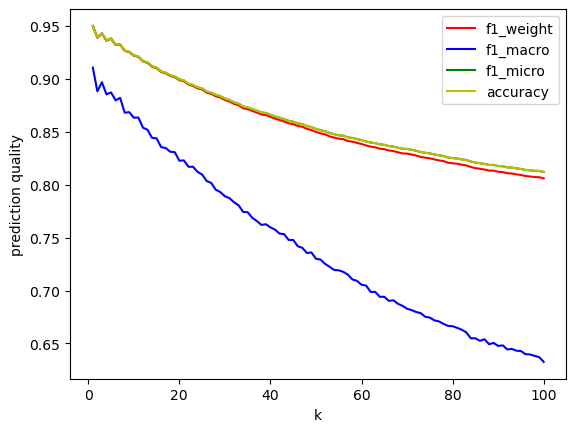

running prediction (latency)...
running prediction (latency)... done
Latency (ms, batch size 581): 179.379
Latency (ms) mean for single item: 14.135
Latency (ms) p90 for single item: 16.185
Latency (ms) p99 for single item: 22.297
Deleted knn-latency-flat-l2-ml-c5-xlarge-1726111758-9364896


In [21]:
import time

instance_types = [
    "ml.c5.xlarge",
    # "ml.p2.xlarge",
]
index2estimator = {
    "flat_l2": knn_estimator_flat_l2,
    # "ivfpq_l2": knn_estimator_ivfpq_l2,
    # "flat_l2_large": knn_estimator_flat_l2_large,
    # "ivfpq_l2_large": knn_estimator_ivfpq_l2_large,
}

eval_results = {}

for index in index2estimator:
    estimator = index2estimator[index]
    eval_results[index] = {}
    for instance_type in instance_types:
        model_name = f"knn_{index}_{instance_type}"
        endpoint_name = "knn-latency-%s-%s-%s" % (
            index.replace("_", "-"),
            instance_type.replace(".", "-"),
            str(time.time()).replace(".", "-"),
        )
        print(f"\nsetting up endpoint for instance_type={instance_type}, index_type={index}")
        pred = predictor_from_hyperparams(
            estimator, index, instance_type, endpoint_name=endpoint_name
        )
        print("")
        eval_result = evaluate(
            pred, test_features, test_labels, model_name=model_name, verbose=True
        )
        eval_result["instance"] = instance_type
        eval_result["index"] = index
        eval_results[index][instance_type] = eval_result
        delete_endpoint(pred)

In [22]:
eval_results

{'flat_l2': {'ml.c5.xlarge': {'f1_weight': [0.9499302225974884,
    0.9387782675380848,
    0.9428456465992533,
    0.9358816162925169,
    0.9379401244972537,
    0.9319053905302738,
    0.9322563388355967,
    0.926460560679944,
    0.9251690276184945,
    0.9217542207718499,
    0.9206950547537005,
    0.9164633109466703,
    0.9149796202811886,
    0.9114180435742966,
    0.9100275997319722,
    0.9063684561696501,
    0.9051174954238551,
    0.9027079311615627,
    0.9014893415072827,
    0.8987582976183256,
    0.8976372697110484,
    0.894500573656794,
    0.8932339494353113,
    0.8908736234892252,
    0.889964711300163,
    0.8868598784815509,
    0.8857797669395098,
    0.883507802388265,
    0.8823132658548722,
    0.8799952181209458,
    0.8785228396739997,
    0.8763245118910271,
    0.8749906954723086,
    0.8721267399441579,
    0.8713156171064061,
    0.8696467672671426,
    0.868128087349151,
    0.8662916490785845,
    0.8657525101095802,
    0.863970792321438,
    0.

Looking at the plots it seems that the performance is best for small values of k. Let’s view some values in a table to get a clear comparison. Below is a table with rows representing the models and columns, the different measurements. We highlight for every model any accuracy score that is at most 0.25% (relative) away from the maximum accuracy among the different values of k

In [23]:
import pandas as pd

k_range = range(1, 13)
df_index = []
data = []
columns_lat = ["latency1K", "latency1_mean", "latency1_p90", "latency1_p99"]
columns_acc = ["acc_%d" % k for k in k_range]
columns = columns_lat + columns_acc

for index, index_res in eval_results.items():
    for instance, res in index_res.items():
        # for sample size?
        df_index.append(index + "_" + instance)
        latencies = np.array(
            [res["Latency"], res["Latency1_mean"], res["Latency1_p90"], res["Latency1_p99"]]
        )
        row = np.concatenate([latencies * 10, res["accuracy"][k_range[0] - 1 : k_range[-1]]])
        row *= 100
        data.append(row)

df = pd.DataFrame(index=df_index, data=data, columns=columns)
df_acc = df[columns_acc]
df_lat = df[columns_lat]


def highlight_apx_max(row):
    """
    highlight the aproximate best (max or min) in a Series yellow.
    """
    max_val = row.max()
    colors = ["background-color: yellow" if cur_val >= max_val * 0.9975 else "" for cur_val in row]

    return colors


df_acc.round(decimals=1).style.apply(highlight_apx_max, axis=1)

,acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10,acc_11,acc_12
flat_l2_ml.c5.xlarge,95.000000,93.900000,94.300000,93.600000,93.800000,93.200000,93.200000,92.700000,92.500000,92.200000,92.100000,91.700000


Let’s review the latencies. We’ll highlight the latencies that are much worse (20% more) than the median value

In [24]:
def highlight_far_from_min(row):
    """
    highlight the aproximate best (max or min) in a Series yellow.
    """
    med_val = row.median()
    colors = ["background-color: red" if cur_val >= med_val * 1.2 else "" for cur_val in row]

    return colors


df_lat.round(decimals=1).style.apply(highlight_far_from_min, axis=0)

,latency1K,latency1_mean,latency1_p90,latency1_p99
flat_l2_ml.c5.xlarge,179.400000,14.100000,16.200000,22.300000


### Accuracy
For optimizing accuracy, the results show that for some of the models, k=1 yields the best results. We may want to play it safe and choose a larger value for k. The reason is that if the data slightly changes over time, the results associated with small values of k tend to change faster than those of larger values of k. A reasonable compromise could be choosing k=5. Not surprisingly, the accuracy becomes better if we choose a larger training set and if we use a brute-force index. This leads to 97% accuracy. For comparison, a linear model trained on the covtype dataset achieves roughly 72% accuracy. This is a pretty solid demonstration of the power of the kNN classifier. If we are willing to get slightly less accurate results but at higher speed, we could choose either a large dataset with an approximate index IVFPQ_l2_large_XX, or a smaller sample size flat_l2_ml_XX. Both achieve roughly 93%-95% precision, yet have much more favorable latency scores.

### Latency
We can see a single-query mean latency of under 10ms in most setting and under 20ms in the remaining. Some of this can likely be attributed to typical system overheads, so results may become better over time. One exception is for flat_l2_large_ml.c5.xlarge, where we pay for using an exact solution on a large dataset by having a latency of about 25ms. There is much more variance in the latency for a batch of roughly 1K points as the relative overhead there is lower. There, the slowest yet most accurate model requires roughly 360ms to return an answer while for the approximate versions we get over X5 speedup. If one would like to have the best accuracy but reduce latency, another option is to use a GPU machine. flat_l2_large_ml.p2.xlarge enjoys the best accuracy while keeping the latency for 1K points at less than 90ms and singe-query p90 latency at 14.2ms. The downside is the dollar cost, since a ml.p2.xlarge machine is more expensive than a ml.c5.xlarge machine.

### Concluding Remarks
We’ve seen how to both train and host an inference endpoint for kNN. We’ve shown the ease of tuning a kNN algorithm and how to experiment with the different parameters, both those required at training and at inference. The experiment on the covtype dataset demonstrates the power of the simple procedure of kNN, especially when considering the final accuracy score of 96.8%, say, compared to linear model that achieves 72.8% accuracy. We explored the tradeoffs between an approximate index, subsampling the data, and using high vs low cost machines. The answer is case dependent and should fit the needs of the particular setup.